In [372]:
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
from model import VSE, order_sim
from data import get_test_loader

from vocab import Vocabulary
import evaluation

import os
import pickle
import time
import itertools

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nltk

from sklearn.neighbors import NearestNeighbors

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [206]:
# prepare VSE model
datapath = "data/"
modelpath = "runs/coco_vse++_resnet_restval_finetune/model_best.pth.tar"
checkpoint = torch.load(modelpath, map_location=lambda storage, loc: storage)
opt = checkpoint['opt']
opt.data_path = datapath

with open(os.path.join(opt.vocab_path,'%s_vocab.pkl' % opt.data_name),'rb') as f:
    vocab = pickle.load(f)
opt.vocab_size = len(vocab)

# construct model
model = VSE(opt)
# load model state
model.load_state_dict(checkpoint['model'])
# switch to evaluate mode
model.val_start()

model.img_enc = model.img_enc.cpu()
model.txt_enc = model.txt_enc.cpu()

=> using pre-trained model 'resnet152'


In [315]:
# build image transform
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
t_list = []
t_list = [transforms.Scale(256), transforms.CenterCrop(224)]
t_end = [transforms.ToTensor(), normalizer]
transform = transforms.Compose(t_list + t_end)

# transform query image
def transformimg(img):
    imgtensor = transform(img)
    imgtensor = imgtensor.unsqueeze(0)
    return imgtensor

# tokenize query text
def tokenize(q):
    starttok, endtok = "<start>", "<end>"
    texttok = nltk.tokenize.word_tokenize(str(q).lower().decode("utf-8"))
    caption = [vocab(starttok)] + [vocab(token) for token in texttok] + [vocab(endtok)]
    target = torch.LongTensor([caption])
    length = [len(caption)]
    return target, length

In [215]:
class MyImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _ = super(MyImageFolder, self).__getitem__(index)
        path = self.imgs[index][0].split("/")[-1]
        return (img, path)

batchnum = 60
val_set = MyImageFolder(root="data/coco/images/", transform=transform)
dataset_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=4)
# start time
startt = time.time()
# accumulate resulting vectors and paths
accumvecs = None
pathslist = []
for i, data in enumerate(dataset_loader, 0):
    imgfeatures, paths = data
    pathslist.append(paths)
    
    imgvec = model.img_enc(torch.autograd.Variable(imgfeatures, volatile=True))
    
    if accumvecs is None:
        accumvecs = np.array(imgvec.data.cpu().numpy())
    else:
        accumvecs = np.append(accumvecs, imgvec.data.cpu().numpy(), axis=0)
    
    currt = time.time()
    print "{} batch(s) computed. accum vector shape: {}. time elapsed: {}" \
        .format(str(i+1), str(accumvecs.shape), str(currt-startt))
    
    if i == batchnum:
        print 'images encoding finished! saving results...'
        
        # save the objects
        all_paths = [i for i in itertools.chain(*pathslist)]
        pickle.dump(accumvecs, open("val2014imgvecs.pkl", "wb"))
        pickle.dump(all_paths, open("val2014paths.pkl", "wb"))
        
        break

1 batch(s) computed. accum vector shape: (64, 1024). time elapsed: 34.607945919
2 batch(s) computed. accum vector shape: (128, 1024). time elapsed: 66.7076659203
3 batch(s) computed. accum vector shape: (192, 1024). time elapsed: 103.313807011
4 batch(s) computed. accum vector shape: (256, 1024). time elapsed: 145.331728935
5 batch(s) computed. accum vector shape: (320, 1024). time elapsed: 180.260349035
6 batch(s) computed. accum vector shape: (384, 1024). time elapsed: 211.811714888
7 batch(s) computed. accum vector shape: (448, 1024). time elapsed: 245.055845022
8 batch(s) computed. accum vector shape: (512, 1024). time elapsed: 277.488296986
9 batch(s) computed. accum vector shape: (576, 1024). time elapsed: 308.947901964
10 batch(s) computed. accum vector shape: (640, 1024). time elapsed: 340.41089797
11 batch(s) computed. accum vector shape: (704, 1024). time elapsed: 369.900508881
12 batch(s) computed. accum vector shape: (768, 1024). time elapsed: 481.116194963
13 batch(s) comp

In [216]:
# load image vectors
imgbasepath = "data/coco/images/val2014/"
imgpathfile = open("val2014paths.pkl", "rb")
imgvfile = open("val2014imgvecs.pkl", "rb")
imgpaths = pickle.load(imgpathfile)
imgvectors = pickle.load(imgvfile)
imgnum = imgvectors.shape[0]

# build indexing for KNN
neighbors = NearestNeighbors(n_neighbors=9, algorithm='ball_tree').fit(imgvectors)

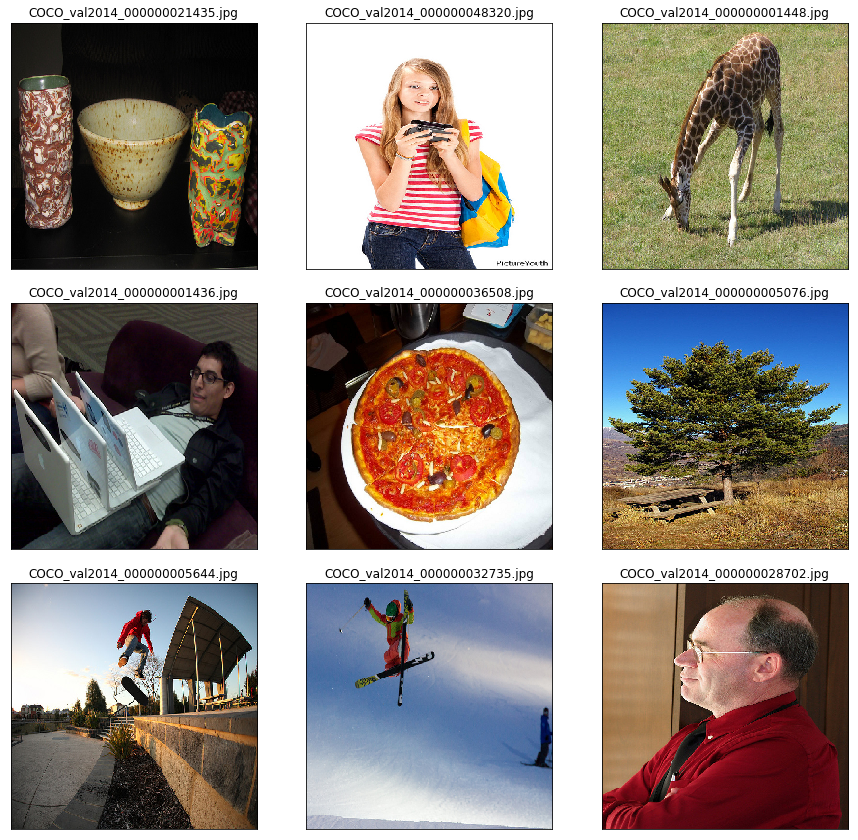

In [270]:
# randomly pick some image example from val set
pylab.rcParams['figure.figsize'] = (15, 15)
plt.subplots_adjust(hspace=.1)
randompick = np.random.choice(imgnum, 9, replace=False)
for i, rand in enumerate(randompick):
    randpath = imgbasepath+imgpaths[rand]
    randimg = Image.open(randpath)
    randimgrz = randimg.resize((256,256))
    sbplt = plt.subplot(3,3,1+i)
    sbplt.set_title(randpath.split("/")[-1])
    sbplt.get_xaxis().set_visible(False)
    sbplt.get_yaxis().set_visible(False)
    plt.imshow(randimgrz)

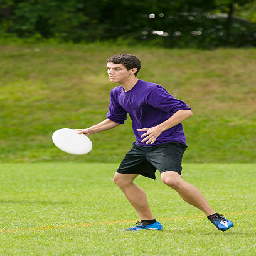

In [320]:
# queried image
querypath = "data/query2.jpg"
queryimgpil = Image.open(querypath)
queryimg = transformimg(queryimgpil)
queryimgpil.resize((256,256))

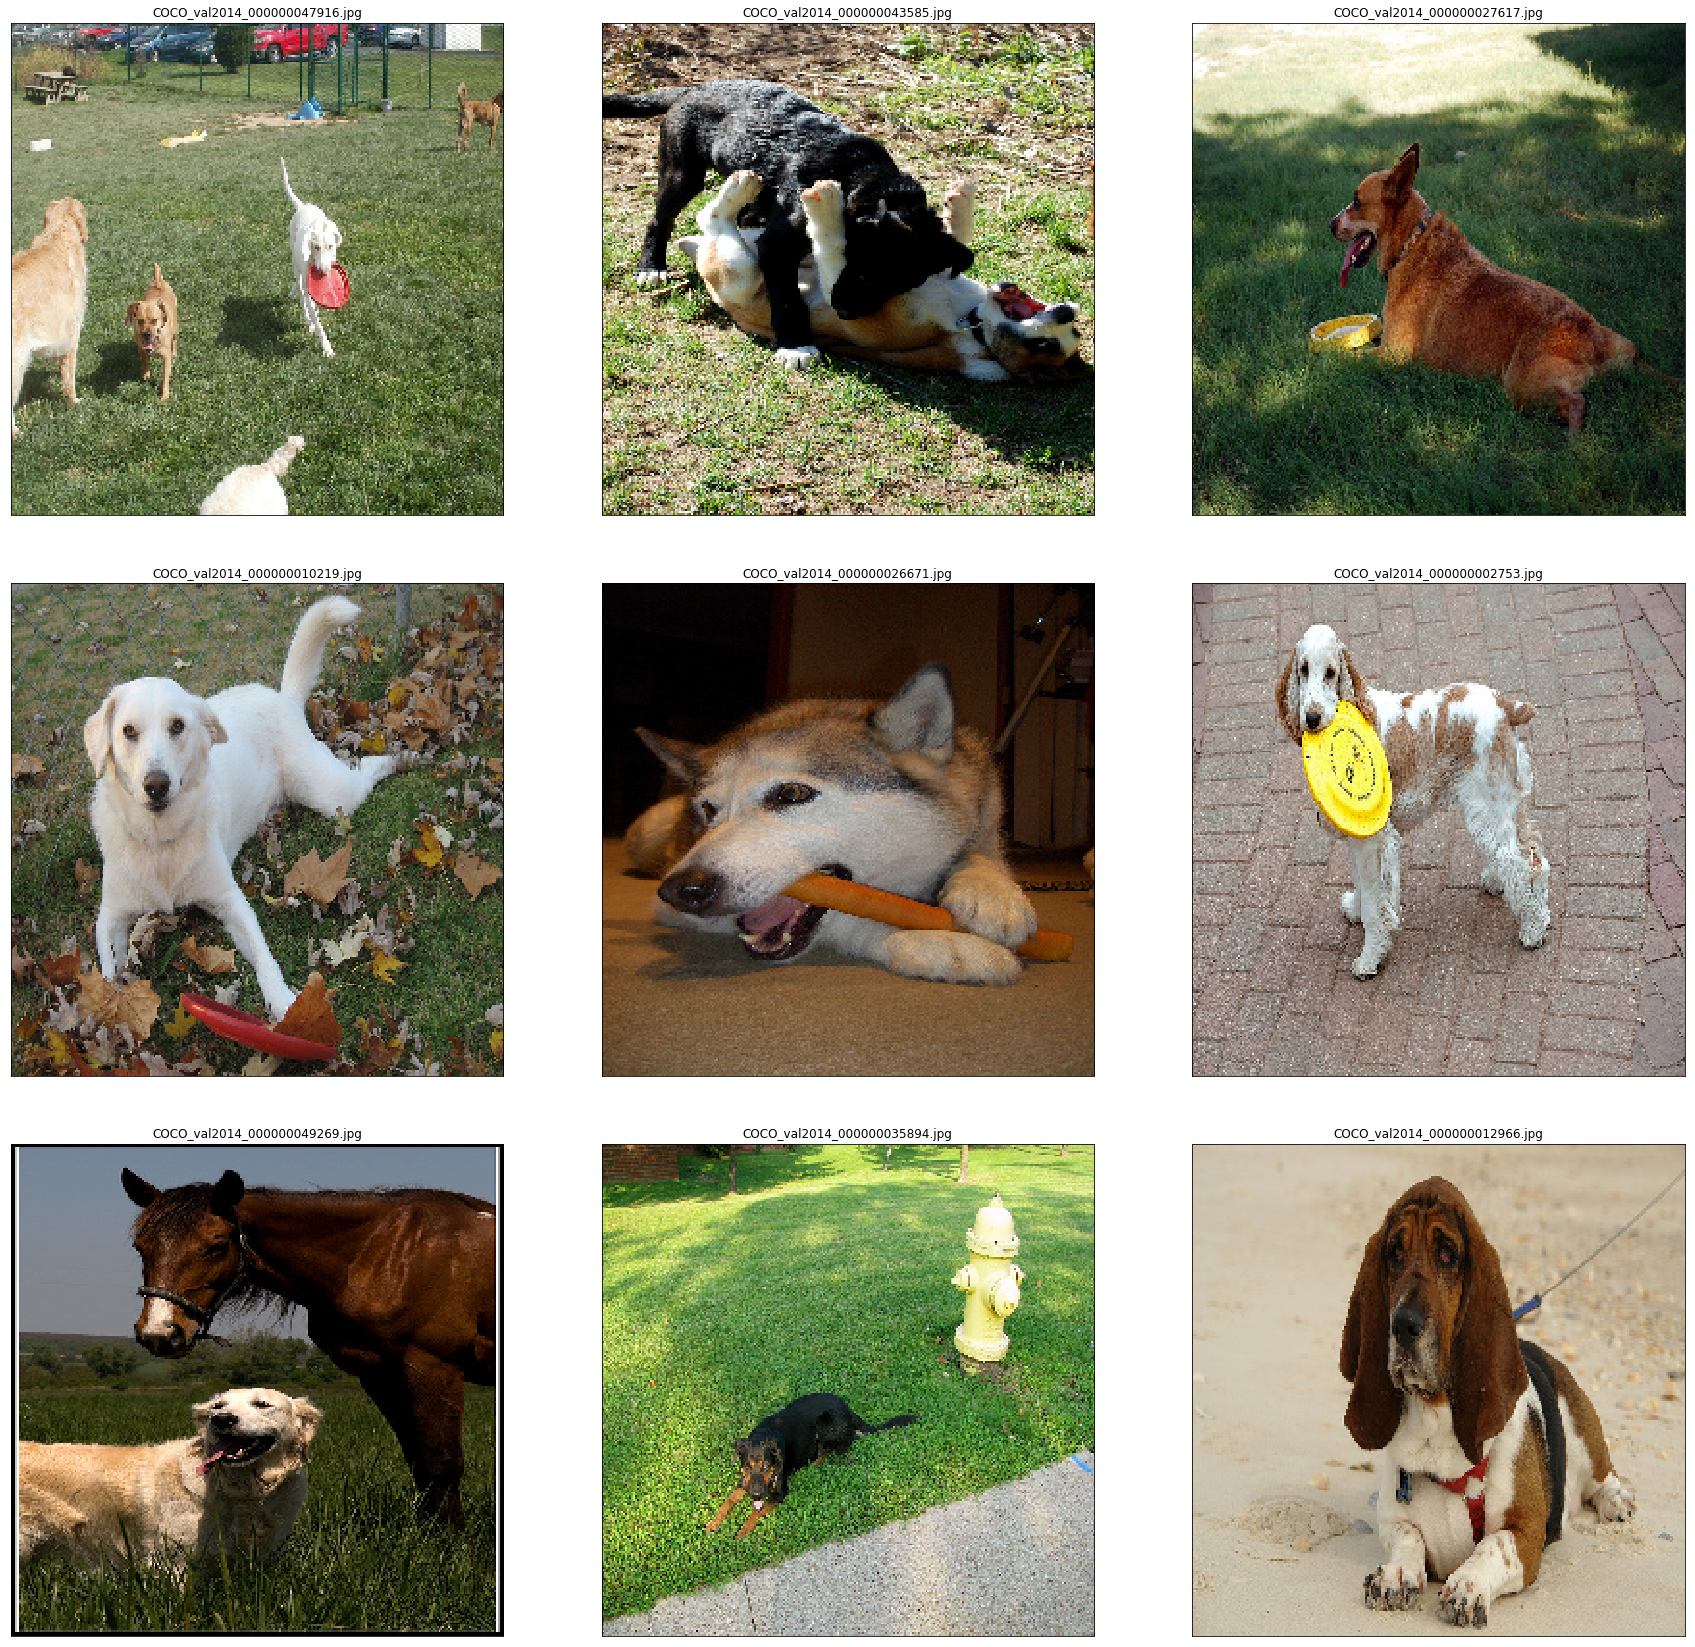

In [288]:
# encode query image to vector & perform KNN search
imgvec = model.img_enc(torch.autograd.Variable(queryimg, volatile=True))
imgvec = imgvec.data.cpu().numpy().squeeze()
distances, indices = neighbors.kneighbors([imgvec])
pylab.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(hspace=.1)
for i, idx in enumerate(indices[0]):
    respath = imgbasepath+imgpaths[idx]
    resimg = Image.open(respath).resize((256,256))
    sbplt = plt.subplot(3,3,1+i)
    sbplt.set_title(respath.split("/")[-1])
    sbplt.get_xaxis().set_visible(False)
    sbplt.get_yaxis().set_visible(False)
    plt.imshow(resimg)

found!


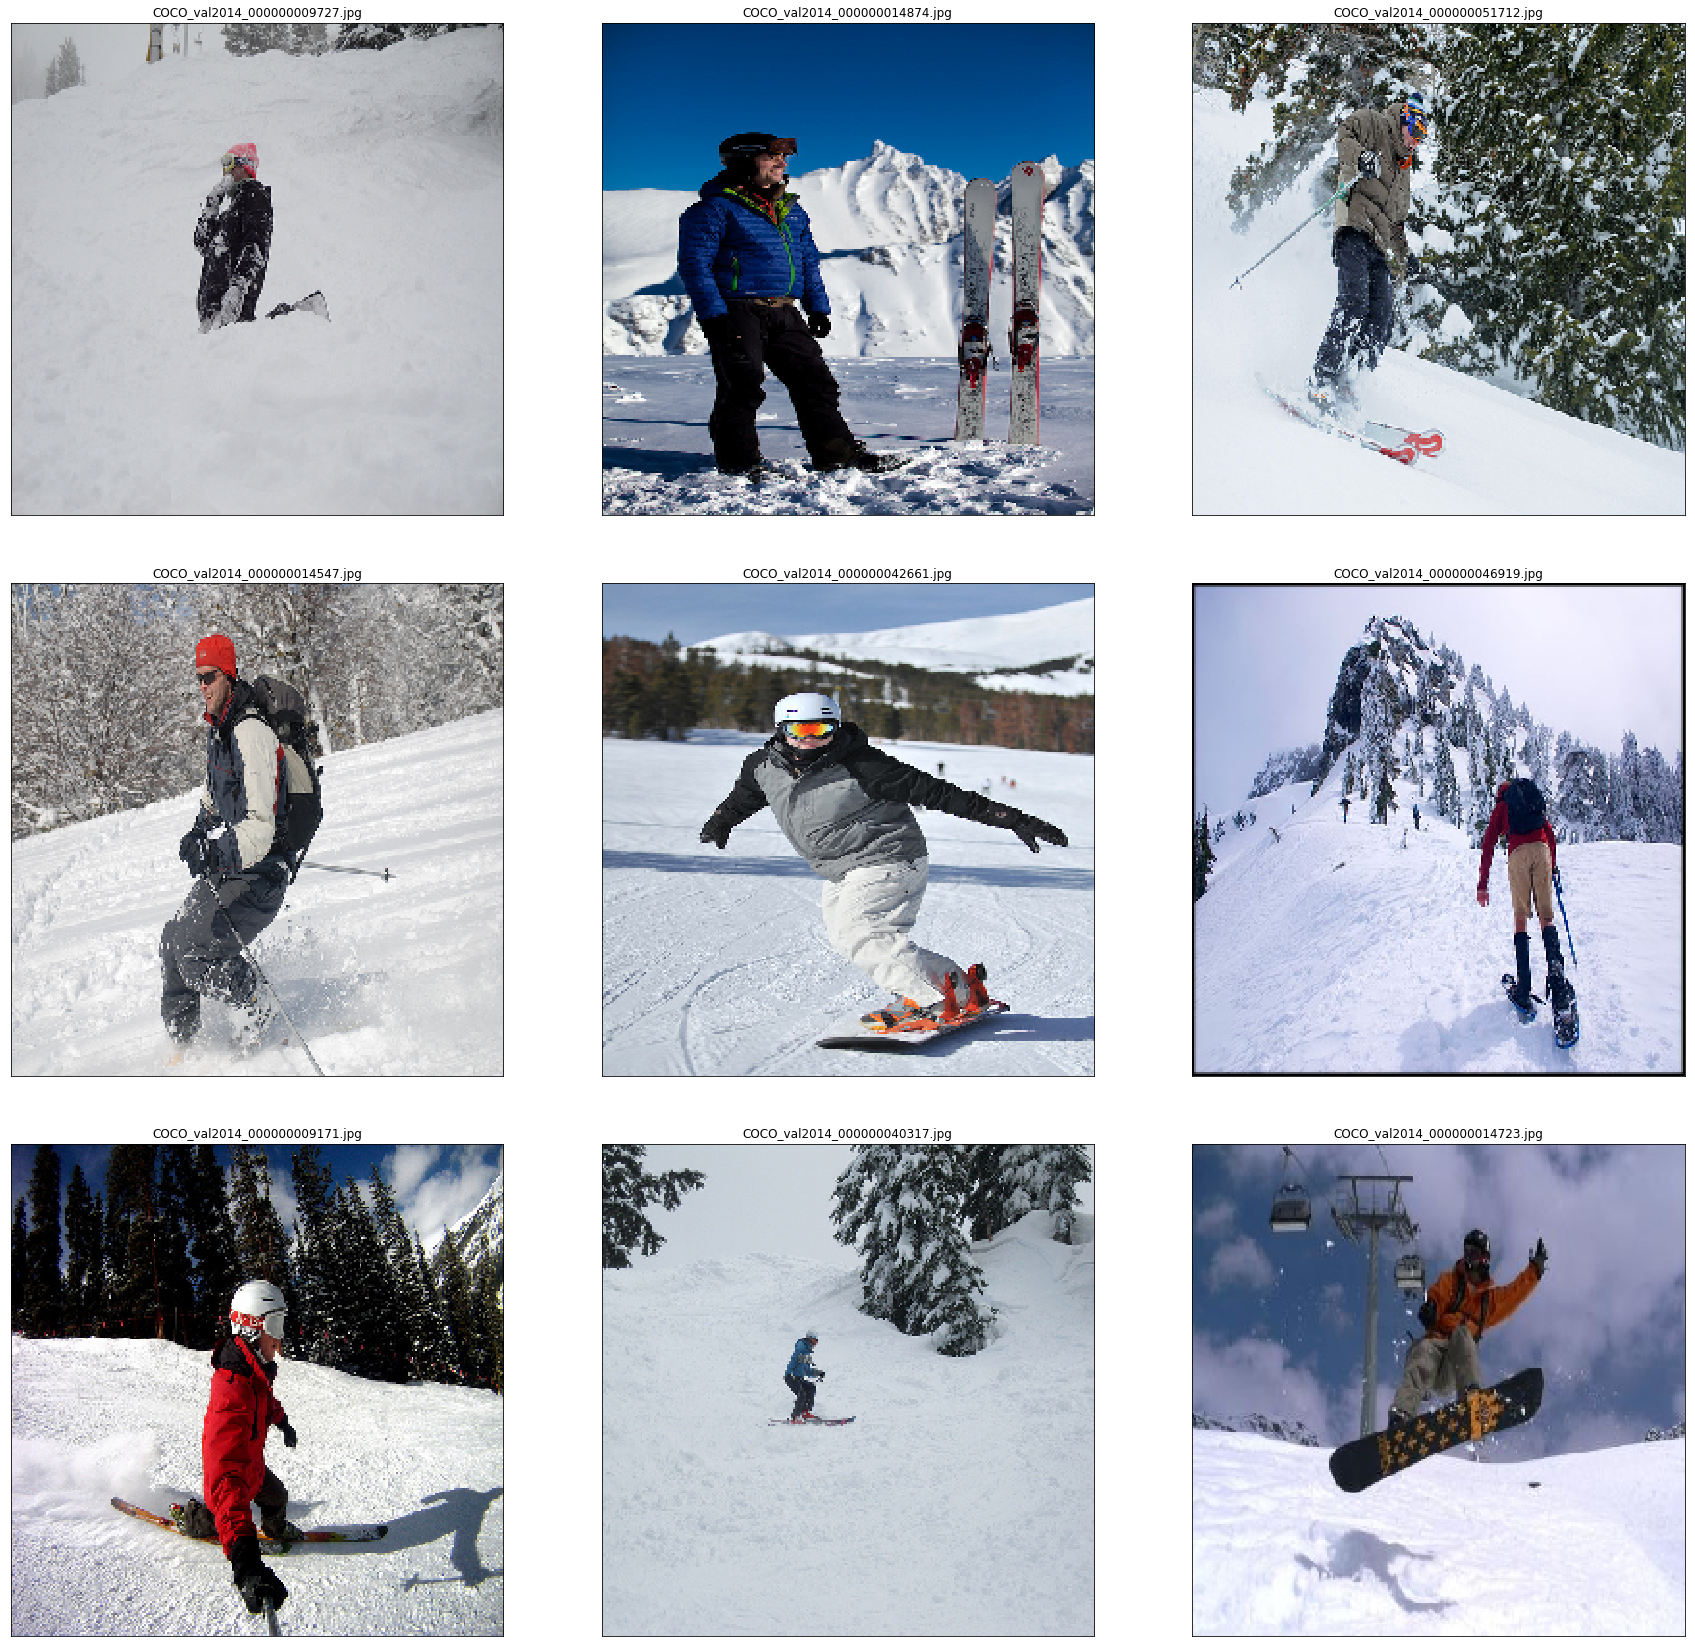

In [317]:
# define text query
textq = "snow boarding"
# text tokenizer 
starttok, endtok = "<start>", "<end>"
texttok = nltk.tokenize.word_tokenize(str(textq).lower().decode("utf-8"))
caption = [vocab(starttok)] + [vocab(token) for token in texttok] + [vocab(endtok)]
target = torch.LongTensor([caption])
length = [len(caption)]

txtvec = model.txt_enc(torch.autograd.Variable(target, volatile=True), length)
txtvec = txtvec.data.cpu().numpy().squeeze()
distances, indices = neighbors.kneighbors([txtvec])
print "found!"
pylab.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(hspace=.1)
for i, idx in enumerate(indices[0]):
    respath = imgbasepath+imgpaths[idx]
    resimg = Image.open(respath).resize((256,256))
    sbplt = plt.subplot(3,3,1+i)
    sbplt.set_title(respath.split("/")[-1])
    sbplt.get_xaxis().set_visible(False)
    sbplt.get_yaxis().set_visible(False)
    plt.imshow(resimg)

In [364]:
# encode text to vector
c1, l1 = tokenize("a dog is running")
c2, l2 = tokenize("a man playing frisbee")

i1 = transformimg(Image.open("data/query.jpg"))
i2 = transformimg(Image.open("data/query2.jpg"))

l = l1+l2
t = torch.stack((c1.squeeze(0), c2.squeeze(0)))
t = model.txt_enc(torch.autograd.Variable(t, volatile=True), l)

i = torch.stack((i1.squeeze(), i2.squeeze()))
i = model.img_enc(torch.autograd.Variable(i, volatile=True))

scores = i.mm(t.t())
diagonal = scores.diag().view(i.size(0), 1)
d1 = diagonal.expand_as(scores)
d2 = diagonal.t().expand_as(scores)

margin = 0
cost_s = (margin - d1 + scores).clamp(-2)
cost_im = (margin - d2 + scores).clamp(-2)

mask = torch.eye(scores.size(0)) > .5
I = torch.autograd.Variable(mask)
cost_s = cost_s.masked_fill_(I, 0)
cost_im = cost_im.masked_fill_(I, 0)
# print i
# print scores
# print diagonal
# print d1
# print d2
print cost_s
print cost_im

cost_s = cost_s.max(1)[0]
cost_im = cost_im.max(0)[0]

print cost_s
print cost_im

Variable containing:
 0.0000 -0.3351
-0.4972  0.0000
[torch.FloatTensor of size 2x2]

Variable containing:
 0.0000 -0.4404
-0.3919  0.0000
[torch.FloatTensor of size 2x2]

Variable containing:
-0.3351
-0.4972
[torch.FloatTensor of size 2]

Variable containing:
-0.3919
-0.4404
[torch.FloatTensor of size 2]



In [374]:
evaluation.evalrank(modelpath, datapath, split='val')

=> using pre-trained model 'resnet152'
Loading dataset
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
Computing results...


ValueError: too many values to unpack